<a href="https://colab.research.google.com/github/OrJaku/others/blob/master/Pandas_proj_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb

import eli5
from eli5.sklearn import PermutationImportance

In [0]:
cd '/content/drive/My Drive/Colab Notebooks/Pandas'

/content/drive/My Drive/Colab Notebooks/Pandas


In [0]:
df = pd.read_hdf('data/car.h5')

### *Tables update

In [0]:
!pip install --upgrade tables
# pip install numpy==1.15.4

###Show data


In [0]:
df.columns.values

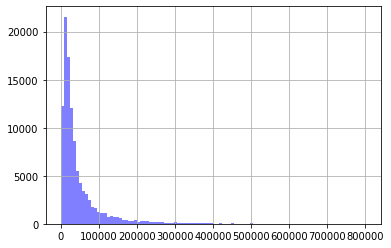

In [0]:
df['price_value'].hist(bins=100, color='b', alpha=0.5)

In [0]:
df['price_value'].describe()

count    106494.000000
mean      47534.137437
std       66308.716918
min         400.000000
25%       13890.000000
50%       25500.000000
75%       52900.000000
max      799900.000000
Name: price_value, dtype: float64

In [0]:
def show_plot(feat_groupby, feat_agg='price_value', agg_features=[np.mean, np.median, np.size], sorting="mean"):
  (
    df
    .groupby(feat_groupby)[feat_agg]
    .agg(agg_features)
    .sort_values(by=sorting, ascending=False)
    .head(50)
  ).plot(kind='bar', figsize=(18,8), subplots=True)


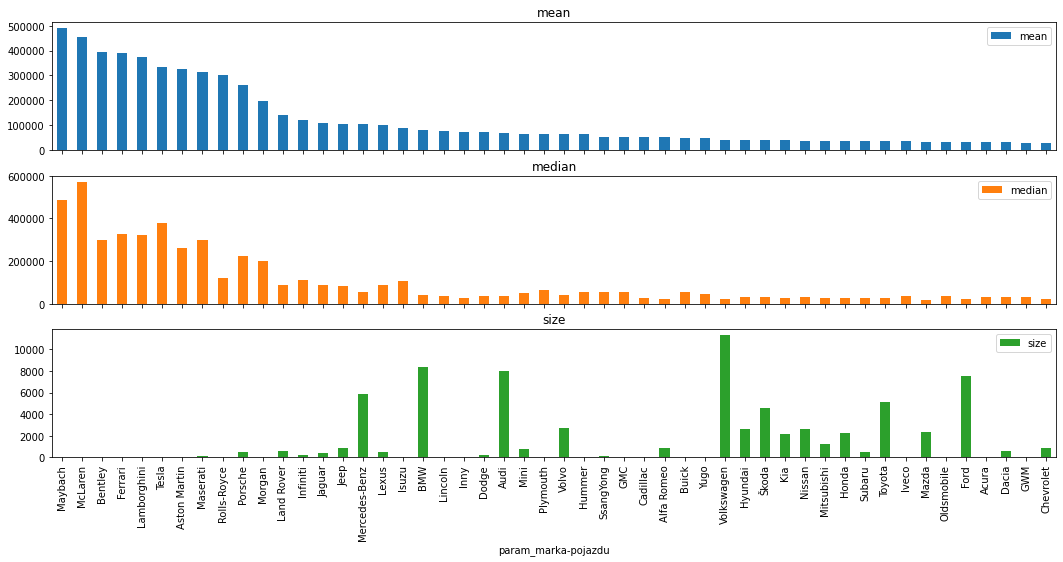

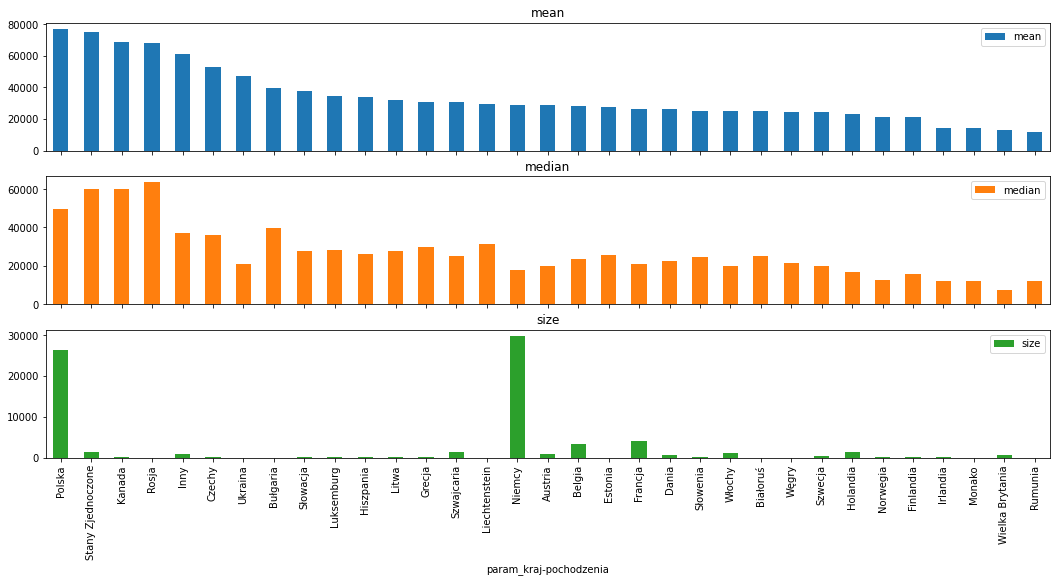

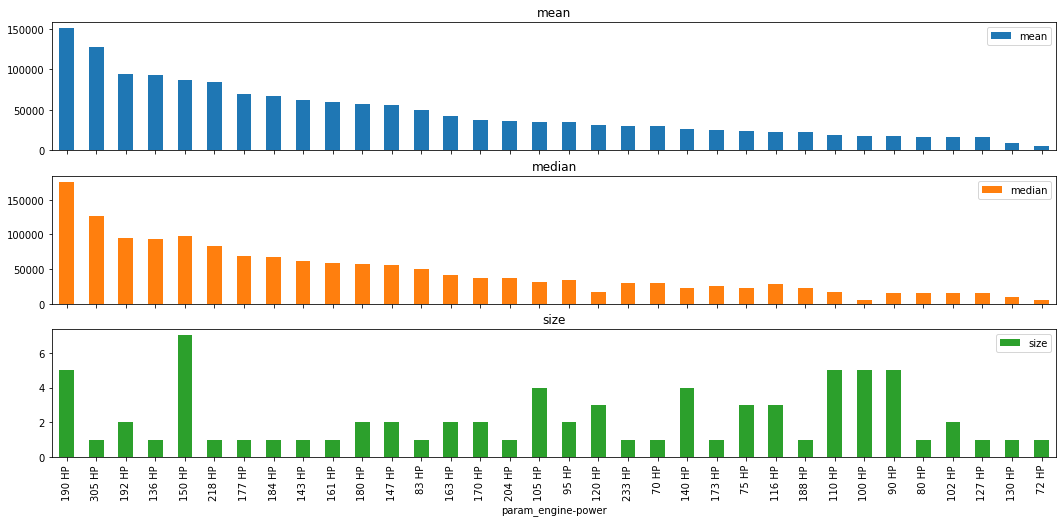

In [0]:
params_list = ['param_marka-pojazdu',"param_kraj-pochodzenia", 'param_engine-power']
for param in params_list:
  show_plot(param)

In [0]:
feats = ['car_id']
X = df[feats].values
y= df['price_value'].values

model = DummyRegressor()
model.fit(X,y)
y_pred = model.predict(X)
mean_absolute_error(y, y_pred)

39465.934630440985

In [0]:
df [df['price_currency'] == "EUR"]

####Update columns value


In [0]:
df.loc[df['price_currency']== "EUR", 'price_value'] = 4.3 * df['price_value'] 
df.loc[df['price_currency']== "EUR", 'price_currency'] = "PLN" 


In [0]:
df['price_currency'].value_counts()

PLN    106494
Name: price_currency, dtype: int64

In [0]:
# cat_feats_clean = []
# for x in df.columns:
#   if x.split('_')[0] == 'feature' or x.split('_')[0] == 'param':
#     x = x.split('_')[1:]
#     x = ''.join(x)
#   else:
#     pass
#   cat_feats_clean.append(x)
# cat_feats_clean
# print(cat_feats_clean)

suffix = "__cat"
for feat in df.columns:
  try:
    if isinstance(df[feat][0], list): 
      continue
  except KeyError:
    continue
  factorize_value = df[feat].factorize()[0]
  if suffix in 'feat':
     df[feat] = factorize_value  
  else:
    df[feat + suffix] =  factorize_value                            

In [0]:
cat_feats = [x for x in df.columns if suffix in x]


In [0]:
cat_feats

In [0]:
df['param_rok-produkcji'] = df['param_rok-produkcji'].map(lambda x: -1 if str(x) == "None" else int(x) )

####DecisionTreeRegressor

In [0]:
def run_model(model, feats):
  X = df[feats].values
  y= df['price_value'].values
  model.fit(X,y)
  y_pred = model.predict(X)
  mean_absolute_error(y, y_pred)
  scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
  np.mean(scores)
  return model, np.mean(scores)

In [0]:
model_fited = run_model(DecisionTreeRegressor(max_depth=5), cat_feats)

In [0]:
model_fited[1]
imp = PermutationImportance(model_fited[0], random_state=1).fit(X, y)
eli5.show_weights(imp, feature_names=cat_feats)


In [0]:
model_fited[1]


####RandomForest

In [0]:
model_fited_2 = run_model(RandomForestRegressor(max_depth=5, n_estimators=50), cat_feats)
model_fited_2[1]
imp = PermutationImportance(model_fited_2[0], random_state=1).fit(X, y)
eli5.show_weights(imp, feature_names=cat_feats)

Weight,Feature
0.2385 ± 0.0086,param_napęd__cat
0.1897 ± 0.0047,param_faktura-vat__cat
0.1623 ± 0.0050,price_value__cat
0.0768 ± 0.0027,param_stan__cat
0.0450 ± 0.0007,feature_kamera-cofania__cat
0.0411 ± 0.0033,param_rok-produkcji__cat
0.0387 ± 0.0019,param_moc__cat
0.0295 ± 0.0015,param_skrzynia-biegów__cat
0.0294 ± 0.0028,param_pojemność-skokowa__cat
0.0193 ± 0.0019,param_marka-pojazdu__cat


In [0]:
model_fited_2[1]

-18566.24168824153

####XGBOOST

In [0]:
cat_feats = ["param_napęd__cat",
"price_value__cat",
"param_rok-produkcji",
"param_stan__cat",
"param_skrzynia-biegów__cat",
"param_moc__cat",
"param_faktura-vat__cat",
"param_marka-pojazdu__cat",
"param_typ__cat",
"feature_kamera-cofania__cat",
"param_pojemność-skokowa__cat",
"seller_name__cat",
"feature_wspomaganie-kierownicy__cat",
"param_model-pojazdu__cat",
"param_kod-silnika__cat",
"param_wersja__cat",
"feature_system-start-stop__cat",
"price_details__cat",
"feature_regulowane-zawieszenie__cat",
"feature_światła-led__cat"]
xgboost_params = {
                "max_depth": 5,
                "n_estimators": 50,
                "learning_rate": 0.1,
                "seed": 0
                  }

In [0]:
X = df[cat_feats].values
y= df['price_value'].values
model_fited_3 = run_model(xgb.XGBRegressor(**xgboost_params), cat_feats)
print(len(cat_feats))
model_fited_3[1]
imp = PermutationImportance(model_fited_3[0], random_state=1).fit(X, y)
eli5.show_weights(imp, feature_names=cat_feats)
print(model_fited_3[1])

[16:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:56:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
20
-11478.885299084346
